In [5]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib as mpl
from matplotlib import pyplot as plt
from pyDOE import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Network

## Building deep feed-forward networks with *PyTorch*

We'll now build a simple deep neural network. Specifically, we'll build a deep network with three hidden layers with 10 neurons in each layer.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^T$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:
\begin{align}
    \mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N], \\
    y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M],
\end{align}
where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$th stimulus. 

The $M$-dimensional vector $\mathbf{h}^{(n)}$ denotes the activations of the **hidden layer** of the network. The reason it is called hidden can be glimpsed from the schematic below, showing how the hidden layer is, in a sense, "hidden" from the input and output of the network. Deeper networks may have multiple hidden layers, but here we'll just focus on a single hidden layer. 

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p>

The following code shows a neural network in PyTorch, using the PyTorch `nn.Module` object class. It contains three key ingredients:

* `__init__()` method to initialize its parameters, like in any other Python class. It takes the following arguments: hidden_size which specifies the number of units in the hidden layer; input size; and num_class which is the number of classes depending on binary or multiclass classification.

* `nn.Linear()` modules, which are built-in PyTorch objects containing all the weights and biases for a given network layer. See [here](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) for documentation. It takes two arguments:
   * \# of inputs to that layer, and 
   * \# of outputs from that layer

  For the input layer, for example, we have:
   * \# of inputs = \# of neurons whose responses are to be decoded ($N$)
   * \# of outputs = \# of hidden layer units ($M$)
  
  PyTorch will initialize all weights and biases randomly.

* `forward()` method, which takes as argument an input to the network and returns the network output. In our case, this comprises computing the output $y$ from a given input $\mathbf{r}$ using the above two equations. We provide the code for doing this using the built-in PyTorch `nn.Linear()` objects.

## Key Component: Activation Function
Activation functions are used to implement a non-linear transformation from the input layer to the hidden layer. With activation function the function takes the following form:
\begin{equation}
    \mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}
where $\phi$ is some non-linear function, referred to as the **activation function**. 

One of the widely used activation function is  "**Re**ctified **L**inear **U**nits", or **ReLU**'s, which can be implemented in PyTorch using `torch.relu()`. The **ReLU** has the following mathmatical expression:
\begin{equation}
  \phi(x) = 
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}

Another famous activation function is Sigmoid or Logistic Activation Function, often called **Sigmoid**, which can be implemented in PyTorch using `torch.sigmoid()`. The **Sigmoid** has the following mathmatical expression:
\begin{equation}
\phi(x)=\frac{1}{1+e^{-x}}
\end{equation}

To learn more about [activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

## Key Component: Loss Function

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense. We need to write some code to change these weights so that the network will be better doing the job. 

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the **squared error**
\begin{equation}
    L = (y - \tilde{y})^2
\end{equation}
where $y$ is the network output and $\tilde{y}$ is the true label. When the output of the nerual network is far from the true label, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is in doing classification or regression task.

PyTorch actually already has a number of built-in loss functions. The one corresponding to squared error is called `nn.MSELoss()`. This will take as arguments a number of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

Another widely used loss function is called **cross entropy loss**, which takes the following mathmatical expression:
\begin{equation}
\text { CrossEntropy Loss }=-\left(y_{i} \log \left(\hat{y}_{i}\right)+\left(1-y_{i}\right) \log \left(1-\hat{y}_{i}\right)\right)
\end{equation}

To learn more about [loss function](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23) 

## Key Component: Optimization method

Our goal is to modify the weights to make the loss $L$ as small as possible on the dataset. To do this, we'll use the **stochastic gradient descent (SGD)** algorithm, which consists of iterating four simple steps:
1. **Randomly sample a *mini-batch* of training data**. This is only strictly necessary when the full data set is too big to pass through the network all at once. That said, using mini-batches turns out to also help avoid overfitting.
2. **Evaluate the loss** at this mini-batch
3. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with one line of code: if the loss is stored in a variable `loss`, all you need to do is run
```
loss.backward()
```
PyTorch will then compute the gradients of this quantity with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), and store them behind the scenes.
4. **Update the network weights** by descending the gradient. In Pytorch, we can do this with one line of code by using built-in optimizers. The SGD optimizer is called `optim.SGD` (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)), and takes as an argument 
  * the parameters to be updated
  * the learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, one would use
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).
  
  To update each of these parameters, we then need only call the `.step()` method of this optimizer:
  ```
  optimizer.step()
  ```
  This single line of code will execute the SGD updates for each parameter given to the optimizer when it was initialized. Note that this is true no matter how big/small the network is, allowing us to use the same two lines of code for any deep network model built using PyTorch.

Finally, an important detail to remember is that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `zero_grad()`, as follows:
```
optimizer.zero_grad()
```

Other important optimization includes AdaGrad (Adaptive Gradient), RMSProp (Root Mean Square Propagation), and Adam (Adaptive Moment Estimation) which take advantage of both AdaGrad and RMSProp. Read this [following article](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) to learn more about the above three methods. 

### Example 1: feed-forward NN with mini-batch SGD

In [49]:
# 1. preprocess the data
df = np.load('Data.npy', allow_pickle = True).item()
X = df['X']
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
# scale and normalize
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
# turn to tensor
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# 2. model
learning_rate = 0.001
num_epochs = 1000
input_size = 10
hidden_size = 10
num_class = 2
batch_size = 100

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        torch.nn.init.xavier_normal_(self.l1.weight, gain=1.0)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        torch.nn.init.xavier_normal_(self.l2.weight, gain=1.0)
        self.Relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, num_class)
        torch.nn.init.xavier_normal_(self.l3.weight, gain=1.0)

    def forward(self, x):
        out = self.l1(x)
        out = self.Relu(out)
        out = self.l2(out)
        out = self.Relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_class)

# 3. loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
train_mse = []
# 4. traing iteration
for epoch in range(num_epochs):
    ishuffle = torch.randperm(X_train.shape[0])  # random ordering of training data
    minibatch_data = torch.split(X_train[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(y_train[ishuffle], batch_size)  # split train_labels into minibatches
    
    for X, y in zip(minibatch_data, minibatch_labels):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(X)
        y = y.reshape(len(y),).long()
        # loss
        loss = criterion(y_predicted, y)
        # backward path
        loss.backward()
        # updates
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        train_mse.append(loss.item())
        print(f'epoch: {epoch+1}, loss: {loss.item():.4f}')

with torch.no_grad():
    outputs = model(X_test)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = predicted.eq(y_test.reshape(len(y_test),)).sum() / float(len(y_test))
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

epoch: 100, loss: 0.0878
epoch: 200, loss: 1.6787
epoch: 300, loss: 1.9183
epoch: 400, loss: 0.1113
epoch: 500, loss: 0.3686
epoch: 600, loss: 0.1975
epoch: 700, loss: 0.5869
epoch: 800, loss: 0.0048
epoch: 900, loss: 0.3501
epoch: 1000, loss: 0.0013
Accuracy of Neural Network is 0.8157


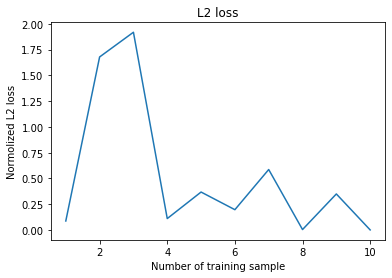

In [50]:
plt.plot(np.linspace(1, 10, 10), train_mse, label='Train')
plt.title('L2 loss')
plt.xlabel('Number of training sample')
plt.ylabel('Normolized L2 loss')
plt.show()

### Example 2: NN with Adam （Adaptive Moment Estimation）

In [55]:
# 1. preprocess the data
df = np.load('Data.npy', allow_pickle = True).item()
X = df['X']
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
# scale and normalize
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
# turn to tensor
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# 2. model
learning_rate = 1e-3
num_epochs = 1000
input_size = 10
hidden_size = 10
num_class = 2
batch_size = 100

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        torch.nn.init.xavier_normal_(self.l1.weight, gain=1.0)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        torch.nn.init.xavier_normal_(self.l2.weight, gain=1.0)
        self.Relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, num_class)
        torch.nn.init.xavier_normal_(self.l3.weight, gain=1.0)

    def forward(self, x):
        out = self.l1(x)
        out = self.Relu(out)
        out = self.l2(out)
        out = self.Relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_class)

# 3. loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
train_mse = []
# 4. traing iteration
for epoch in range(num_epochs):
    # zero gradient
    optimizer.zero_grad()
    # forward path
    y_predicted = model(X_train)
    y_train = y_train.reshape(len(y_train),).long()
    # loss
    loss = criterion(y_predicted, y_train)
    # backward path
    loss.backward()
    # updates
    optimizer.step()
        
    if (epoch+1) % 100 == 0:
        train_mse.append(loss.item())
        print(f'epoch: {epoch+1}, loss: {loss.item():.4f}')

with torch.no_grad():
    outputs = model(X_test)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = predicted.eq(y_test.reshape(len(y_test),)).sum() / float(len(y_test))
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

epoch: 100, loss: 0.4908
epoch: 200, loss: 0.3864
epoch: 300, loss: 0.3645
epoch: 400, loss: 0.3559
epoch: 500, loss: 0.3506
epoch: 600, loss: 0.3467
epoch: 700, loss: 0.3432
epoch: 800, loss: 0.3392
epoch: 900, loss: 0.3351
epoch: 1000, loss: 0.3304
Accuracy of Neural Network is 0.8088


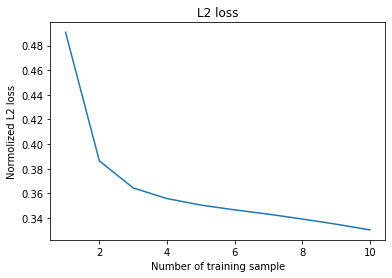

In [56]:
plt.plot(np.linspace(1, 10, 10), train_mse, label='Train')
plt.title('L2 loss')
plt.xlabel('Number of training sample')
plt.ylabel('Normolized L2 loss')
plt.show()

### Example for you: Use the following code to play with different parameters and evaluate using accuracy and loss
parameters to play with:
1. number of epochs: num_epochs 
2. learning_rate (which is usually 1e-3)
3. number of layers
4. number of neurons in each layer: hidden_size 
5. batch_size 
6. optimizer: SGD, Adagrad, RMSprop, Adam  [documentation](https://pytorch.org/docs/stable/optim.html)
7. loss function: nn.CrossEntropyLoss, nn.MSELoss, nn.L1Loss [documentation](https://pytorch.org/docs/stable/nn.html)

In [59]:
# 1. preprocess the data
df = np.load('Data.npy', allow_pickle = True).item()
X = df['X']
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
# scale and normalize
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
# turn to tensor
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# 2. model
learning_rate = 0.001
num_epochs = 1000
input_size = 10
hidden_size = 10
num_class = 2
batch_size = 100

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        torch.nn.init.xavier_normal_(self.l1.weight, gain=1.0)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        torch.nn.init.xavier_normal_(self.l2.weight, gain=1.0)
        self.Relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, num_class)
        torch.nn.init.xavier_normal_(self.l3.weight, gain=1.0)

    def forward(self, x):
        out = self.l1(x)
        out = self.Relu(out)
        out = self.l2(out)
        out = self.Relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_class)

# 3. loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
train_mse = []
# 4. traing iteration
for epoch in range(num_epochs):
    # zero gradient
    optimizer.zero_grad()
    # forward path
    y_predicted = model(X_train)
    y_train = y_train.reshape(len(y_train),).long()
    # loss
    loss = criterion(y_predicted, y_train)
    # backward path
    loss.backward()
    # updates
    optimizer.step()
        
    if (epoch+1) % 100 == 0:
        train_mse.append(loss.item())
        print(f'epoch: {epoch+1}, loss: {loss.item():.4f}')

with torch.no_grad():
    outputs = model(X_test)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = predicted.eq(y_test.reshape(len(y_test),)).sum() / float(len(y_test))
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

epoch: 100, loss: 0.5475
epoch: 200, loss: 0.3902
epoch: 300, loss: 0.3657
epoch: 400, loss: 0.3553
epoch: 500, loss: 0.3479
epoch: 600, loss: 0.3435
epoch: 700, loss: 0.3408
epoch: 800, loss: 0.3385
epoch: 900, loss: 0.3362
epoch: 1000, loss: 0.3340
Accuracy of Neural Network is 0.8088
